In [1]:
from pyeeg.solvers import *

In [2]:
A = np.array([[4, 1], [1, 3]])
b = np.array([1, 2])
A = np.random.rand(5, 5)
# A bit of multicolinearity in A, not rank deficient though, but towards ill-conditioning
A[0] = A[2] * 0.1 + np.random.rand(5)
A = A @ A.T
b = np.random.rand(5)
x0 = np.zeros_like(b)
# Regularised solutions
cg_solution = conjugate_gradient(A, b, x0, lambda_=.00001)
svd_solution = svd_solver(A, b, lambda_=0.00001)
assert np.allclose(cg_solution, svd_solution), "Conjugate gradient and SVD solutions do not match."
# Unregularised solutions
pseudo_inverse_solution = np.linalg.pinv(A) @ b
cg_solution = conjugate_gradient(A, b, x0, lambda_=0.0)
svd_truncated_solution = svd_solver(A, b, lambda_=1-1e-8, truncated_svd=True, verbose=True)
assert np.allclose(pseudo_inverse_solution, svd_truncated_solution), "Pseudo inverse and SVD truncated solutions do not match."
assert np.allclose(cg_solution, svd_truncated_solution), "Conjugate gradient and SVD truncated solutions do not match."

Keeping 5 components (out of 5)
Variance explained: 1.0
Singular values: [6.49727027 0.83048834 0.30006519 0.08761891 0.01032167]


In [ ]:
import numpy as np
from pyeeg.utils import lag_matrix

def lag_matrix_np(x, lags, mode='valid', fill_value=0.):
    x = np.asarray(x)
    n = len(x)
    lags = np.asarray(lags)
    min_lag = lags.min()
    max_lag = lags.max()
    
    if mode == 'valid':
        start = max(0, -min_lag)
        end = n - max_lag
        X = np.empty((end - start, len(lags)), dtype=x.dtype)
        for i, lag in enumerate(lags):
            X[:, i] = x[start + lag : end + lag]
        return X

    elif mode == 'full':
        X = np.full((n, len(lags)), fill_value, dtype=x.dtype)
        for i, lag in enumerate(lags):
            if lag < 0:
                X[-lag:, i] = x[:n + lag]
            elif lag > 0:
                X[:n - lag, i] = x[lag:]
            else:
                X[:, i] = x
        return X

    else:
        raise ValueError("mode must be 'valid' or 'full'")

def lag_matrix_np2(x, lags, mode='valid', fill_value=0.):
    x = np.asarray(x)
    n = len(x)
    lags = np.asarray(lags)
    min_lag = lags.min()
    max_lag = lags.max()
    
    if mode == 'valid':
        start = max(0, -min_lag)
        end = n - max_lag
        X = np.empty((end - start, len(lags)), dtype=x.dtype)
        for i, lag in enumerate(lags):
            X[:, i] = x[start - lag : end - lag]
        return X

    elif mode == 'full':
        X = np.full((n, len(lags)), fill_value, dtype=x.dtype)
        for i, lag in enumerate(lags):
            if lag < 0:
                X[-lag:, i] = x[:n - lag]
            else:
                X[:n - lag, i] = x[-lag:]
        return X

    else:
        raise ValueError("mode must be 'valid' or 'full'")


In [169]:
tker, ker = dummy_trf_kernel()
t, x = simluate_pulse_inputs()
y = simulate_trf_output(tker, ker, x)
lags = np.round(tker * 100).astype(int)
X = lag_matrix_np(x, -lags, mode='full')
# X = lag_matrix(x, lags, filling=0., drop_missing=False)

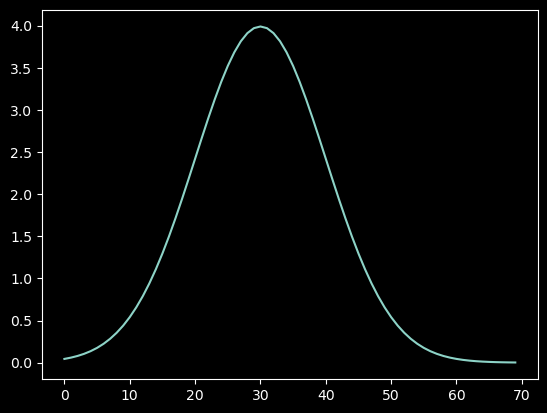

In [170]:
plt.plot(np.linalg.lstsq(X, y[:, None], rcond=None)[0])

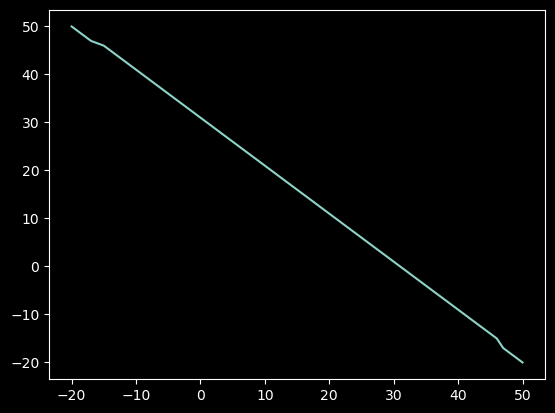

In [156]:
plt.plot(lags, trf.lags)

INFO:pyeeg:Lagging matrix...
INFO:pyeeg:Computing coefficients..
INFO:pyeeg:Computing statistics...
INFO:pyeeg:Lagging matrix...
INFO:pyeeg:Computing coefficients..
INFO:pyeeg:Computing statistics...


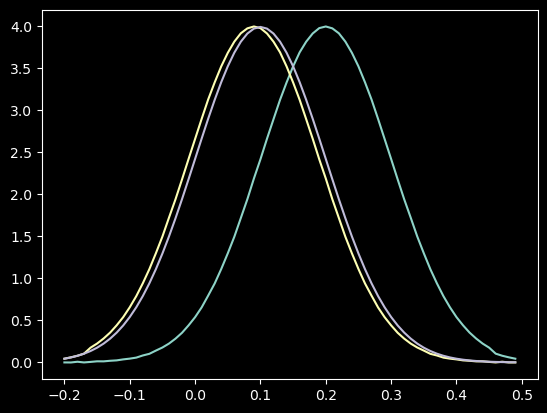

In [157]:
trf = TRFEstimator(times=tker, srate=100)
trf.fit(X, y[:, None], lagged=True, drop=False)
fig = trf.plot();
trf.fit(x[:, None], y[:, None], lagged=False, drop=False)
trf.plot(ax=fig.gca());
ax = fig.gca()
ax.plot(tker, ker)

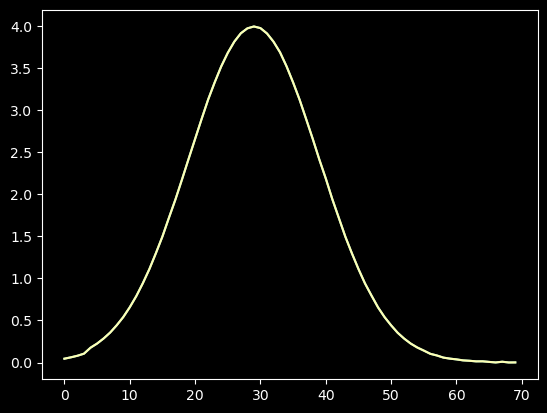

In [159]:
plt.plot(b2)
plt.plot(b)

In [158]:
b = np.linalg.inv(X.T@X + 0.0001*np.eye(70)) @ X.T @ y
b2 = np.linalg.pinv(X) @ y
assert np.allclose(b, b2, atol=1e-4), "Lagged matrix regression coefficients do not match."

In [31]:
x = np.arange(8)
X_full = lag_matrix_np(x, lags[::-1], mode='full')
X_full_old = lag_matrix(x, lags, drop_missing=False, filling=0)
print(X_full)

[[2 0 0]
 [3 1 0]
 [4 2 1]
 [5 3 2]
 [6 4 3]
 [7 5 4]
 [0 6 5]
 [0 7 6]]


In [46]:
K = np.array([1., 0.5, 0.2, -0.1])

In [52]:
Y = X_full_test @ K

In [60]:
X_full

array([[2, 1, 0, 0],
       [3, 2, 1, 0],
       [4, 3, 2, 1],
       [5, 4, 3, 2],
       [0, 5, 4, 3]])

In [63]:
x = np.array([1, 2, 3, 4, 5])
lags = np.array([-1, 0, 1, 2])
# Test lag_matrix_np function
X_valid = lag_matrix_np(x, -lags, mode='valid')
X_full = lag_matrix_np(x, -lags, mode='full')
# Test lag_matrix function
X_valid_test = lag_matrix(x, lags, drop_missing=True)
X_full_test = lag_matrix(x, lags, drop_missing=False, filling=0)

# Check if the results are the same
assert np.array_equal(X_valid, X_valid_test), "Valid mode results do not match."
assert np.array_equal(X_full, X_full_test), "Full mode results do not match."

### Performance test

In [17]:
# Test lag_matrix_np function
%timeit X_valid = lag_matrix_np(x, lags, mode='valid')
%timeit X_full = lag_matrix_np(x, lags, mode='full')
# Test lag_matrix function
%timeit X_valid_test = lag_matrix(x, lags, drop_missing=True)
%timeit X_full_test = lag_matrix(x, lags, drop_missing=False, filling=0)

9.94 μs ± 149 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
11 μs ± 340 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
1.14 ms ± 30.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
771 μs ± 22.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
# Large array test
x = np.random.rand(10000)
lags = np.arange(-100, 101, 1)
# Test lag_matrix_np function
%timeit X_valid = lag_matrix_np(x, lags, mode='valid')
%timeit X_full = lag_matrix_np(x, lags, mode='full')
# Test lag_matrix function
%timeit X_valid_test = lag_matrix(x, lags, drop_missing=True)
%timeit X_full_test = lag_matrix(x, lags, drop_missing=False, filling=0)

8.14 ms ± 195 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.93 ms ± 204 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
60.3 ms ± 454 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
41.3 ms ± 279 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Example simulation TRF

In [ ]:
from pyeeg.simulate import dummy_trf_kernel, simulate_pulse_inputs, simulate_trf_output
from pyeeg import TRFEstimator
from pyeeg.utils import lag_matrix
import matplotlib.pyplot as plt
import numpy as np

In [22]:
tker, ker = dummy_trf_kernel(kernel_type='bipolar')
# ker = np.diff(np.r_[ker[0], ker])

t, x = simulate_pulse_inputs()
y = simulate_trf_output(tker, ker, x)

trf = TRFEstimator(tmin=-0.2, tmax=0.4, srate=100)
trf.fill_lags()
lags = trf.lags
x_lagged = lag_matrix(x, lags[::-1], drop_missing=True)
# x_lagged = lag_matrix_np(x, lags, mode='valid')
trf.fit(x_lagged, y[:, None], lagged=True)


f, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(tker, ker, label='True kernel')
trf.plot(ax=ax[0], plot_kws=dict(label='TRF estimate', ls='--'))
ax[0].legend()
ax[0].set_xlabel('Time lag (s)')
ax[1].plot(t, y, label='output', c='C3')
ax[1].plot(t, x, label='input', c='C2')
ax[1].legend()
ax[1].set_xlabel('Time (s)')
ax[1].set_xlim([0, 3])

NameError: name 'simulate_pulse_inputs' is not defined